### 第二十四組 : PTT 三峽車禍事件情緒分析

M13B020007   陳學蒨

M134020039   顏淳如

## 大綱
1. 利用CKIP進行自然語言處理
2. 利用SnowNLP進行情緒分析

In [147]:
# # 安裝會使用到的套件
# # 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install -U ckiptagger\[tf,gdown\]
# %pip install wordcloud SnowNLP

In [148]:
# 確認當前工作目錄
# %pwd

In [149]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [150]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

In [151]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=b09fc890-f59e-4ffa-8265-f48061276ab0
To: /Users/yanchunru/Desktop/my-project/data.zip
100%|██████████| 1.88G/1.88G [29:29<00:00, 1.06MB/s]


In [152]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/Users/miniconda3/envs/SMA2025/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/miniconda3/envs/SMA2025/lib/python3.11/site-packages/ckiptagger/model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/Users/miniconda3/envs/SMA2025/lib/python3.11/site-packages/ckiptagger/model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.co

## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理
資料來源：

平台：PTT 八卦版

關鍵字：「三峽車禍」、「余文正」、「北大國小」、「行人優先」、「交通事故」等

時間範圍：2025/5/15 ～ 2025/6/10

篩選後共 1216 篇文章

In [153]:
## 讀取文章
df = pd.read_csv('/Users/yanchunru/Desktop/my-project/raw_data/car_accident_2025.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1747553431....,[新聞]快新聞／基隆死亡車禍！16歲少年無照雙,2025-05-18 15:30:29,coon182,Gossiping,民視\n\n快新聞／基隆死亡車禍！16歲少年無照雙載過彎撞分隔島 釀1死1命危\n\n即時中...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Dinenger"", ""...",27.53.66.52,2025-05-19 01:16:24,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1747554300....,Re:[新聞]快新聞／基隆死亡車禍！16歲少年無照雙,2025-05-18 15:44:57,hayate232,Gossiping,每次看到這新聞我反而不會關注在無照，而是駕駛習慣 這種駕駛習慣有駕照也是很糟糕\n\n看起來...,[],114.43.13.228,2025-05-19 01:16:28,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1747643840....,[新聞]快訊／三峽北大國小旁車輛暴衝！釀10多,2025-05-19 16:37:18,sukiya,Gossiping,ETtoday\n\n快訊／三峽北大國小旁車輛暴衝！釀10多人傷 其中3人無呼吸心跳\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Jkyzer"", ""cm...",27.247.192.69,2025-05-20 01:17:30,ptt


In [154]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP 處理相關function

In [155]:
# 自定義辭典
with open('/Users/yanchunru/Desktop/my-project/dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)


[(2, {'車禍': 500.0, '自撞': 500.0, '機車': 500.0, '騎乘': 500.0, '駕駛': 500.0, '酒駕': 500.0, '超速': 500.0, '過彎': 500.0, '失控': 500.0, '撞擊': 500.0, '暴衝': 500.0, '測繪': 500.0, '送醫': 500.0, '傷亡': 500.0, '死亡': 500.0, '命危': 500.0, '受傷': 500.0, '傷者': 500.0, '傷重': 500.0, '警消': 500.0}), (3, {'分隔島': 500.0, '搶救中': 500.0, '消防隊': 500.0, '安樂區': 500.0, '三峽區': 500.0, '國小旁': 500.0, '國光街': 500.0, '復興路': 500.0}), (4, {'交通事故': 500.0, '普重機車': 500.0, '無照駕駛': 500.0, '撞分隔島': 500.0, '肇事責任': 500.0, '抽血酒測': 500.0, '呼吸心跳': 500.0, '宣告不治': 500.0, '意識不清': 500.0, '緊急搶救': 500.0, '警方指出': 500.0, '警方呼籲': 500.0}), (5, {'中央分隔島': 500.0, '無呼吸心跳': 500.0, '交通警察隊': 500.0})]


In [156]:
print(dictionary2)

[(2, {'車禍': 500.0, '自撞': 500.0, '機車': 500.0, '騎乘': 500.0, '駕駛': 500.0, '酒駕': 500.0, '超速': 500.0, '過彎': 500.0, '失控': 500.0, '撞擊': 500.0, '暴衝': 500.0, '測繪': 500.0, '送醫': 500.0, '傷亡': 500.0, '死亡': 500.0, '命危': 500.0, '受傷': 500.0, '傷者': 500.0, '傷重': 500.0, '警消': 500.0}), (3, {'分隔島': 500.0, '搶救中': 500.0, '消防隊': 500.0, '安樂區': 500.0, '三峽區': 500.0, '國小旁': 500.0, '國光街': 500.0, '復興路': 500.0}), (4, {'交通事故': 500.0, '普重機車': 500.0, '無照駕駛': 500.0, '撞分隔島': 500.0, '肇事責任': 500.0, '抽血酒測': 500.0, '呼吸心跳': 500.0, '宣告不治': 500.0, '意識不清': 500.0, '緊急搶救': 500.0, '警方指出': 500.0, '警方呼籲': 500.0}), (5, {'中央分隔島': 500.0, '無呼吸心跳': 500.0, '交通警察隊': 500.0})]


In [157]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [158]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['民視'], ['快新聞基隆死亡車禍', '歲少年無照雙載過彎撞分隔島釀死命危'], ['即時中心潘柏廷報導'], ['基隆市安樂區今日凌晨發生嚴重車禍事故'], ['名歲賴姓少年無照騎車，並載著歲']]
['民視', '快新聞基隆死亡車禍', '歲少年無照雙載過彎撞分隔島釀死命危', '即時中心潘柏廷報導', '基隆市安樂區今日凌晨發生嚴重車禍事故']


In [159]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 379.4046747684479


In [160]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,民視,Nc
1,1,快,VH
2,1,新聞,Na
3,1,基隆,Nc
4,1,死亡,VH


In [161]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,民視,ORG
1,1,基隆,GPE
2,1,即時中心,ORG
3,1,潘柏廷,PERSON
4,1,基隆市,GPE


In [162]:
sentence_table.head()

,system_id,sentence
0,1,民視
1,1,快新聞基隆死亡車禍
2,1,歲少年無照雙載過彎撞分隔島釀死命危
3,1,即時中心潘柏廷報導
4,1,基隆市安樂區今日凌晨發生嚴重車禍事故


In [163]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 312篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 300篇有抓到ner

total posts numbers: 1216
posts have NER: 1114


In [164]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table_accident.csv', index = False)
entity_table.to_csv('raw_data/entity_table_accident.csv', index = False)
sentence_table.to_csv('raw_data/sentence_table_accident.csv', index = False)

In [165]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_accident.csv") 
entity_table = pd.read_csv("raw_data/entity_table_accident.csv") 
sentence_table = pd.read_csv("raw_data/sentence_table_accident.csv") 

###  探索分析 - NER

In [166]:
entity_table['ner'].unique()

array(['ORG', 'GPE', 'PERSON', 'DATE', 'TIME', 'FAC', 'LOC', 'NORP',
       'CARDINAL', 'LANGUAGE', 'QUANTITY', 'ORDINAL', 'WORK_OF_ART',
       'EVENT', 'MONEY', 'LAW', 'PERCENT', 'PRODUCT'], dtype=object)

In [167]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
13,PERSON,2928
4,GPE,2117
11,ORG,1732
1,DATE,1470
7,LOC,1083
0,CARDINAL,681
16,TIME,542
3,FAC,397
9,NORP,230
10,ORDINAL,148


Text(0.5, 0, 'Frequency')

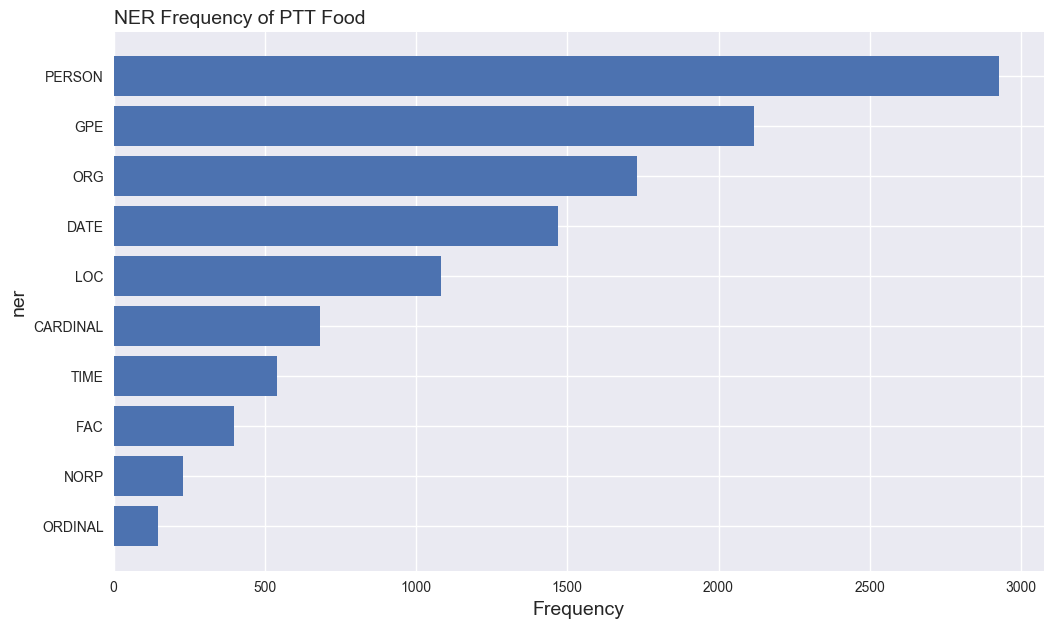

In [168]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

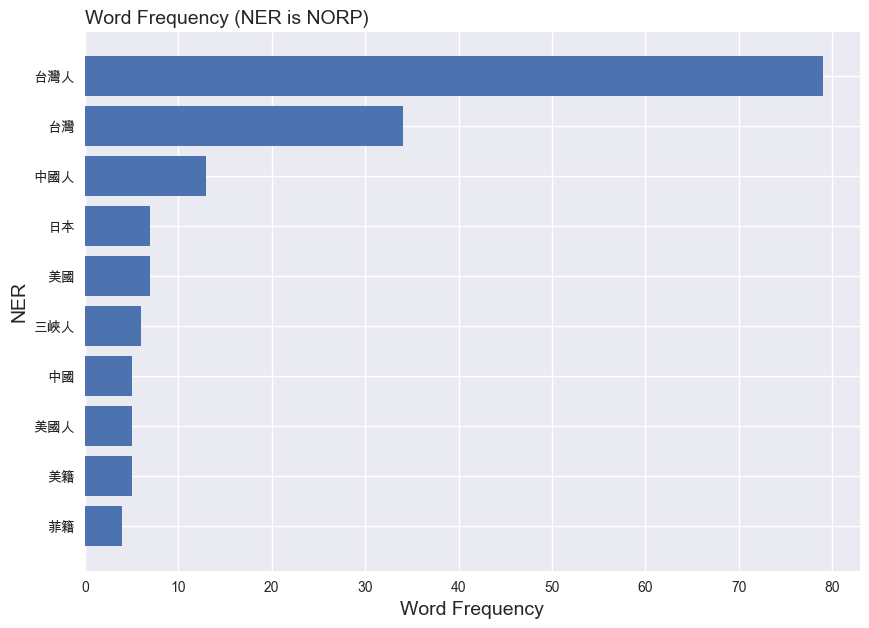

In [169]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

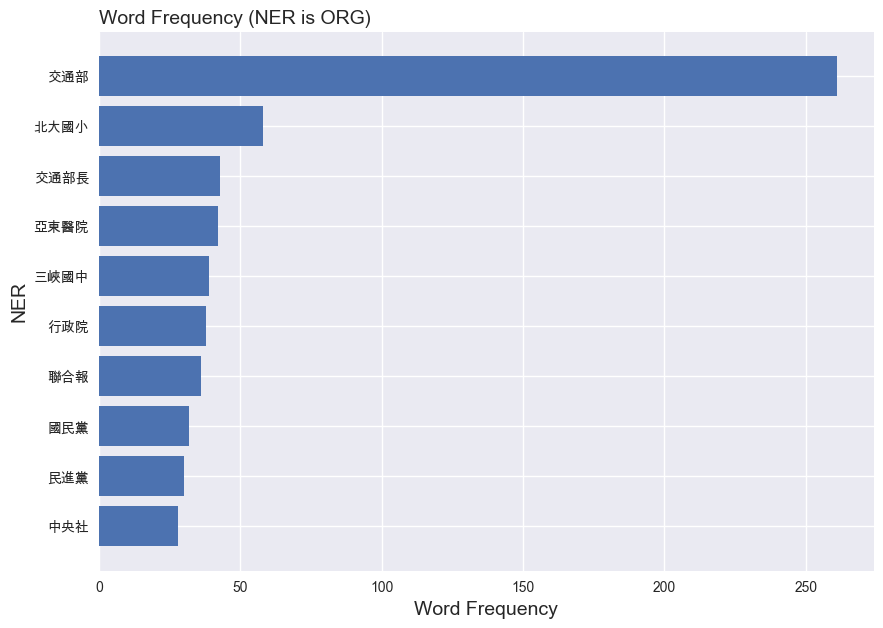

In [170]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到交通部出現頻率最高，顯示跟事故後續政策、責任釐清相關

其他高頻的組織例如 北大國小、亞東醫院、行政院、國民黨等，代表事件影響涵蓋教育、醫療與政治層面。

媒體（聯合報、中央社） 也頻繁出現，顯示傳播強度高

### 涉及到的人名(PERSON)

Text(0.5, 0, 'Word Frequency')

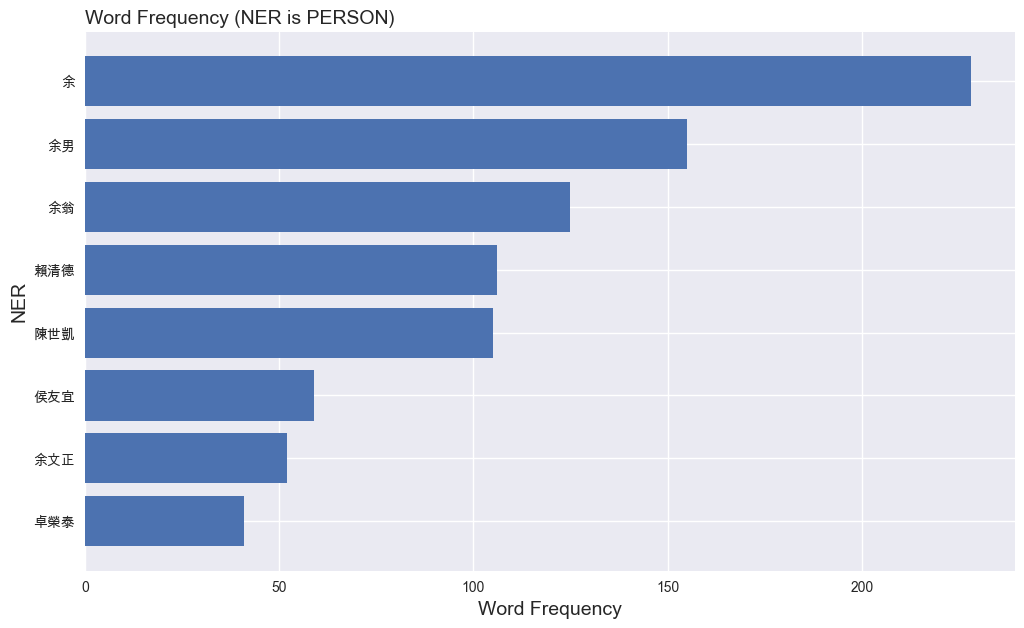

In [171]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

可以看到討論度最高的為肇事者-余姓老翁

賴清德 陳世凱 等政治人物頻繁被提及，表示事件與政治回應有關

下面找出「余姓」相關文章，與後續情緒分析一起做探索

In [172]:
keyword_list = ['余姓']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(20)

余姓：121篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
55,56,https://www.ptt.cc/bbs/Gossiping/M.1747650808....,[新聞]北大國小重大車禍肇事者余姓老翁暫脫險,2025-05-19 18:33:23,LIN9,Gossiping,聯合\n\n北大國小重大車禍 肇事者余姓老翁暫脫險 總統趕赴土城醫院\n\n2025-05-...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""TackoFall"", ...",27.247.64.162,2025-05-20 01:18:57,ptt
67,68,https://www.ptt.cc/bbs/Gossiping/M.1747651536....,[問卦]交通部:三峽駕駛人2月剛換照且未曾違規,2025-05-19 18:45:34,PealRay,Gossiping,交通部表示，本案經查肇事余姓駕駛人，年齡為78歲，經查於114年2月20日於本所進行高\n齡...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""BlueBird5566...",223.137.109.9,2025-05-20 01:19:10,ptt
72,73,https://www.ptt.cc/bbs/Gossiping/M.1747651868....,[新聞]三峽重大車禍 交通部520周年記者會緊急,2025-05-19 18:51:06,novashine,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\nEttoday\n2.記者署名:\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""shokotan"", ""...",223.140.173.73,2025-05-20 01:19:17,ptt
77,78,https://www.ptt.cc/bbs/Gossiping/M.1747652306....,[新聞]三峽重大車禍交通部：78歲駕駛今年2月才換駕照,2025-05-19 18:58:24,hkr91511208,Gossiping,1.媒體來源:\nEttoday\n\n2.記者署名:\n周湘芸／台北報導\n\n3.完整新...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxc8424"", ""c...",121.254.86.28,2025-05-20 01:19:31,ptt
103,104,https://www.ptt.cc/bbs/Gossiping/M.1747656167....,[新聞]三峽3死車禍！肇事翁曾獲「模範父親」,2025-05-19 20:02:44,omanorboyo,Gossiping,1.媒體來源:\n2.記者署名:黃翎瑄\n3.完整新聞標題:\n三峽3死車禍！肇事翁曾獲「模...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",111.251.190.15,2025-05-20 01:20:16,ptt
105,106,https://www.ptt.cc/bbs/Gossiping/M.1747656319....,[新聞]暴衝撞死3人12傷！78歲翁「曾獲模範父親,2025-05-19 20:05:17,emperor,Gossiping,媒體來源:中時\n記者署名:柯毓庭\n完整新聞標題:獨家》暴衝撞死3人12傷！78歲翁「曾獲...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""cuteSquirrel...",106.105.44.109,2025-05-20 01:20:16,ptt
128,129,https://www.ptt.cc/bbs/Gossiping/M.1747658417....,[新聞]快訊／90分考卷噴飛！三峽「同班3女學生,2025-05-19 20:40:14,Waitaha,Gossiping,1.媒體來源:\nETTODAY\n\n2.記者署名:\n記者黃彥傑、陳以昇、鄒鎮宇／新北報...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""WolfTeacher""...",61.228.217.179,2025-05-20 01:20:48,ptt
129,130,https://www.ptt.cc/bbs/Gossiping/M.1747658455....,[新聞]獨／三峽重大車禍78歲肇事者曾獲模範父親,2025-05-19 20:40:53,lili712,Gossiping,聯合新聞網\n\n記者李定宇\n\n獨／三峽重大車禍78歲肇事者曾獲模範父親 酒測值為零\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""dean1990"", ""...",223.136.175.89,2025-05-20 01:20:48,ptt
138,139,https://www.ptt.cc/bbs/Gossiping/M.1747659917....,[新聞]新北三峽重大交通事故交通部成立緊急應,2025-05-19 21:05:15,muchire,Gossiping,新北三峽重大交通事故 交通部成立\n緊急應變中心\n中央廣播電台\n\n2025-05-19...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""WenliYang"", ...",223.23.50.201,2025-05-20 01:21:09,ptt
203,204,https://www.ptt.cc/bbs/Gossiping/M.1747671258....,[問卦]會有人去亞東醫院堵人嗎,2025-05-20 00:14:16,lance810422,Gossiping,如題 今天三峽發生那場車禍真的讓人覺得非常悲憤\n\n幹他媽的垃圾余姓駕駛 你就是個殺人犯 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""gn134679"", ""...",101.8.248.236,2025-05-20 01:23:07,ptt


###  探索分析 - POS

In [173]:
pos_table['pos'].unique()

array(['Nc', 'VH', 'Na', 'Nf', 'VA', 'Nb', 'VE', 'Nd', 'VJ',
       'COMMACATEGORY', 'Cbb', 'VC', 'Di', 'VCL', 'Ng', 'VG', 'Dfa', 'D',
       'P', 'Ncd', 'VB', 'Nes', 'VK', 'Neqb', 'FW', 'VL', 'Nep', 'Nh',
       'V_2', 'SHI', 'DE', 'Nv', 'Da', 'Dk', 'Neqa', 'VHC', 'Caa', 'A',
       'VF', 'VI', 'Cab', 'T', 'VD', 'Neu', 'I', 'DM', 'VAC', 'Dfb',
       'PARENTHESISCATEGORY', 'Cba', 'COLONCATEGORY', 'PERIODCATEGORY'],
      dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [174]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,43318
5,D,20946
35,VC,15598
41,VH,12814
17,Nc,9994
29,P,7368
32,VA,6339
6,DE,6022
38,VE,5922
25,Nf,4802


/var/folders/mp/l0nd6q_x3h78djb6cyyc9j6h0000gn/T/ipykernel_1980/2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


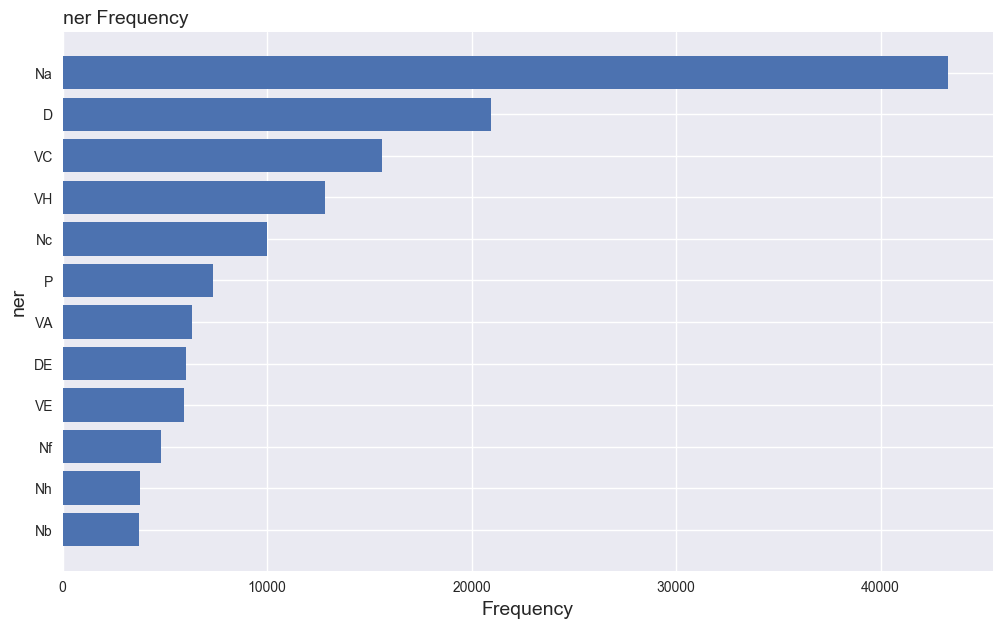

In [175]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)

In [176]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
49,余姓,198
58,余男,154
61,余翁,134
967,陳世凱,106
877,賴清德,106
72,侯友宜,60
53,余文正,56
736,聯合報,47
941,長庚,45
114,卓榮泰,41


/var/folders/mp/l0nd6q_x3h78djb6cyyc9j6h0000gn/T/ipykernel_1980/488784228.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


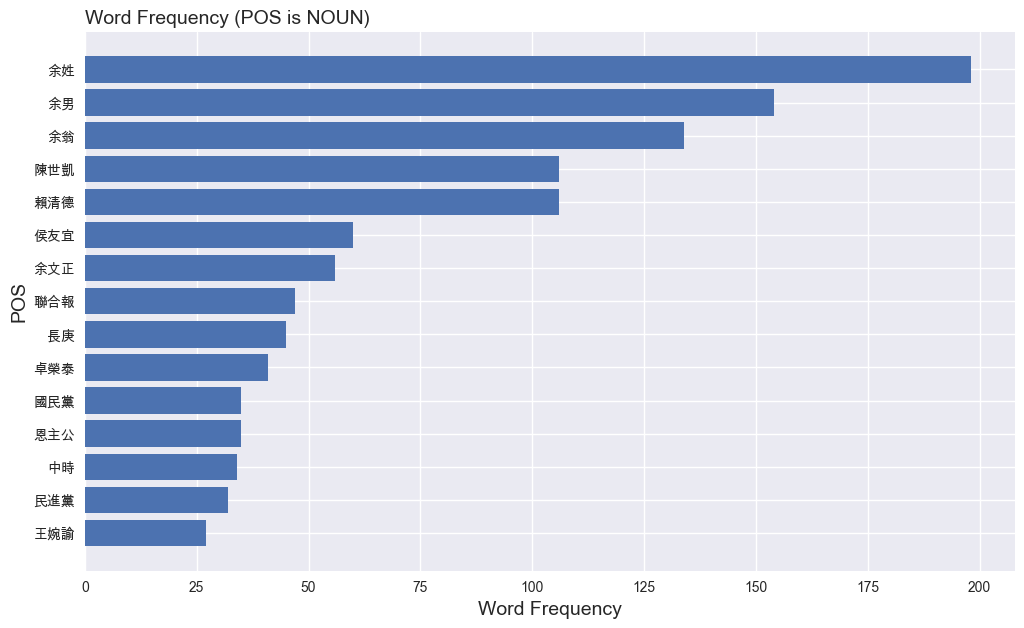

In [177]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到除了剛才看到的人名和組織，有多出王婉諭

加上前面看到人物和組織 間接反映出大家對提出交通法規改革的討論度較高的

### 涉及到的動詞(VERB)

In [178]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
2017,駕駛,727
1546,衝撞,216
907,撞死,208
1807,連結,170
1457,署名,162
1816,進行,146
1757,轉載,138
1889,釐清,133
244,協助,128
887,撞上,102


/var/folders/mp/l0nd6q_x3h78djb6cyyc9j6h0000gn/T/ipykernel_1980/29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


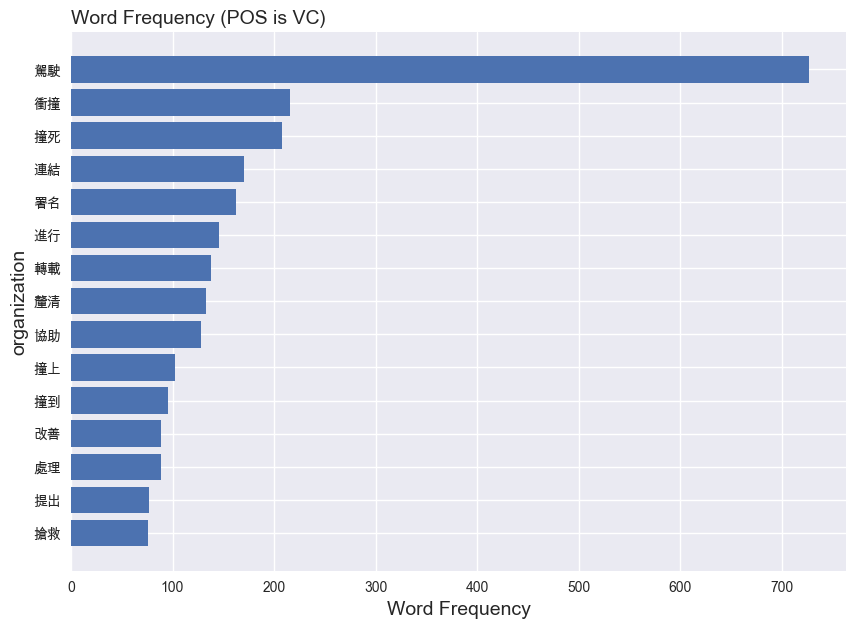

In [179]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到有像是駕駛 衝撞 撞死 的詞彙 表示情緒和事件的具體行為描述非常相關

出現 搶救 這個詞彙 反映後續行動上的討論

還有「處理、改善、提出」這些詞彙， 反映後續對交通法規政策上的討論

## 4. 利用SnowNLP進行情緒分析

使用先前NER得到的「余姓」相關文章，看看相關文章的情緒表現。

In [180]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

In [181]:
sentence_table = pd.read_csv("/Users/yanchunru/Desktop/my-project/raw_data/sentence_table_accident.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource
642,56,聯合,2025-05-19 18:33:23,ptt
643,56,北大國小重大車禍肇事者余姓老翁暫脫險總統趕赴土城醫院,2025-05-19 18:33:23,ptt
644,56,聯合報記者李定宇劉懿萱張策新北即時報導,2025-05-19 18:33:23,ptt


In [182]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,sentence,artDate,dataSource,sentimentValue
642,56,聯合,2025-05-19 18:33:23,ptt,0.351928
643,56,北大國小重大車禍肇事者余姓老翁暫脫險總統趕赴土城醫院,2025-05-19 18:33:23,ptt,0.714065
644,56,聯合報記者李定宇劉懿萱張策新北即時報導,2025-05-19 18:33:23,ptt,0.124410


In [183]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    3.509000e+03
mean     4.602348e-01
std      3.321620e-01
min      5.280157e-08
25%      1.363162e-01
50%      4.719843e-01
75%      7.583096e-01
max      9.999980e-01
Name: sentimentValue, dtype: float64

| 指標      | 數值           | 說明                                   |
| ------- | ------------ | ------------------------------------ |
| `count` | 1223         | 資料筆數，有 1223 筆情緒數值                    |
| `mean`  | 0.4747       | 平均情緒值，接近 0.5，整體偏中性                   |
| `std`   | 0.3332       | 標準差，代表情緒分布有一定的離散程度，分布廣泛              |
| `min`   | 0.0000000528 | 最小值，非常接近 0，代表有極端負向的情緒                |
| `25%`   | 0.1513       | 第 1 四分位數，25% 的文章情緒值低於 0.15，偏負向       |
| `50%`   | 0.4988       | 中位數，約 0.5，顯示整體情緒分布均勻，中性為主            |
| `75%`   | 0.7709       | 第 3 四分位數，75% 的情緒值低於 0.77，代表四分之一偏明顯正向 |
| `max`   | 0.9999959    | 最大值，非常接近 1，代表有極端正向的情緒                |


<Axes: >

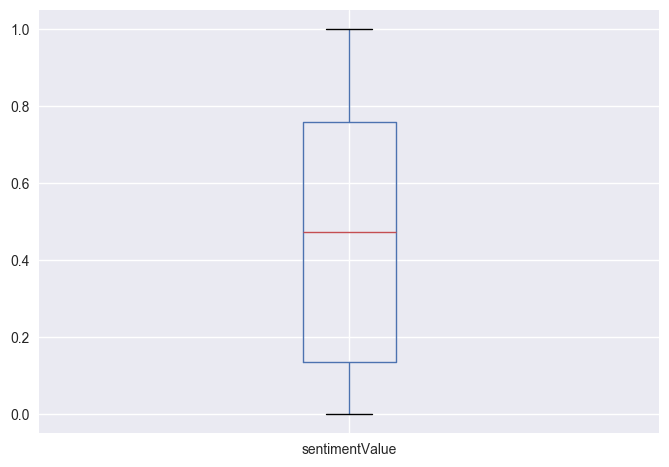

In [184]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

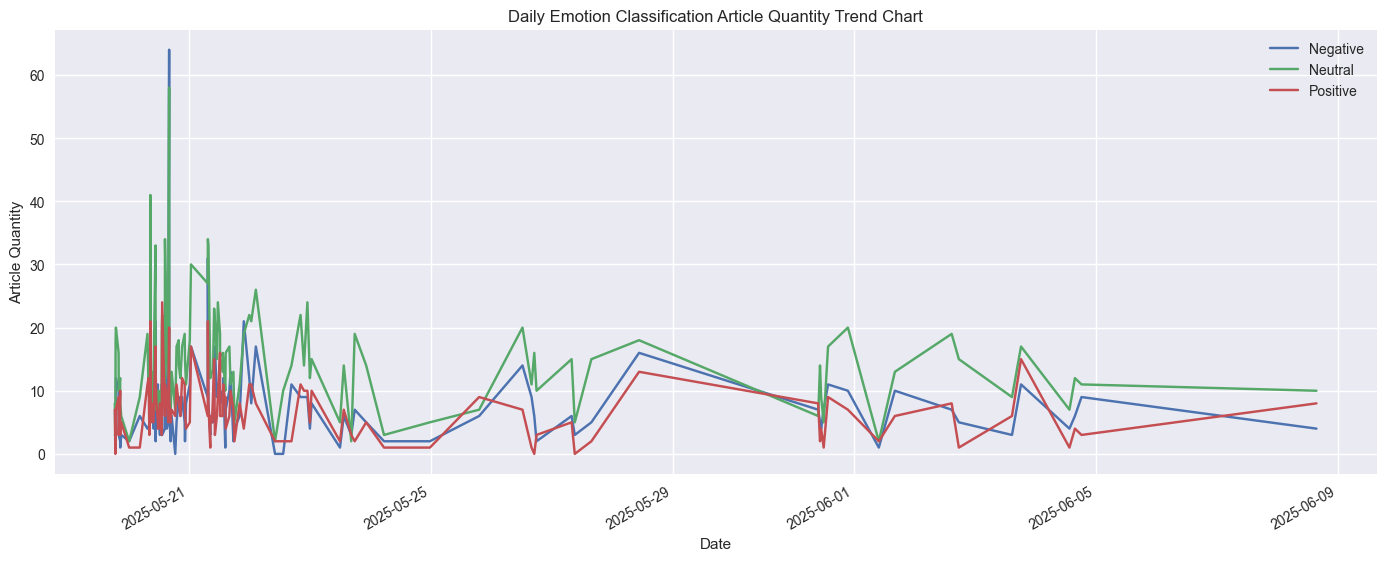

In [ ]:
# 建立副本並轉換時間格式
sent_df = sentiment_date.copy()
sent_df['artDate'] = pd.to_datetime(sent_df['artDate'])

# 根據四分位數分類情緒
def classify_sentiment(val):
    if val <= 0.15:
        return 'Negative'
    elif val >= 0.77:
        return 'Positive'
    else:
        return 'Neutral'

sent_df['sentiment_class'] = sent_df['sentimentValue'].apply(classify_sentiment)

# 計算每天各情緒類別的文章數量
daily_sentiment_counts = sent_df.groupby(['artDate', 'sentiment_class']).size().unstack(fill_value=0)

# 畫圖：每日情緒分類文章數量趨勢
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(14, 6))

for col in ['Negative', 'Neutral', 'Positive']:
    if col in daily_sentiment_counts.columns:
        plt.plot(daily_sentiment_counts.index, daily_sentiment_counts[col], label=col)

plt.title('Daily Emotion Classification Article Quantity Trend Chart')
plt.xlabel('Date')
plt.ylabel('Article Quantity')
plt.legend()
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()




05-21 是輿情最高峰日

輿情在一週內迅速下降，顯示社群對突發事件反應強烈但短期

情緒以負向為主，佐證社群普遍對事故存在強烈不滿與情緒宣洩

而正向情緒比例低，暗示官方、醫療或媒體安撫力道較弱

### 詞彙探索

In [186]:
# 篩時間
target_day = pd.to_datetime('2025-05-20')
next_day = target_day + pd.Timedelta(days=1)

filter_sentiment = sent_df[
    (sent_df['artDate'] >= target_day) &
    (sent_df['artDate'] < next_day) &
    (sent_df['sentimentValue'] < 0.15)
]


filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue,sentiment_class
2696,204,幹他媽的垃圾余姓駕駛你就是個殺人犯你躲不掉的,2025-05-20 00:14:16,ptt,0.003573,Negative
2697,204,他媽的為什麼死掉的不是你,2025-05-20 00:14:16,ptt,0.071083,Negative
3091,239,我就個人行車經驗來試著推測狀況,2025-05-20 04:26:52,ptt,0.006906,Negative
3096,239,因前有兩輛機車而無法得行而急停,2025-05-20 04:26:52,ptt,0.125741,Negative
3097,239,此時不知道機車是何時在暫停區前,2025-05-20 04:26:52,ptt,0.021972,Negative


In [187]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,204,0.003573,如
1,204,0.003573,題
2,204,0.003573,今天
3,204,0.003573,三峽
4,204,0.003573,發生


In [188]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 負面詞彙文字雲

In [189]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種']


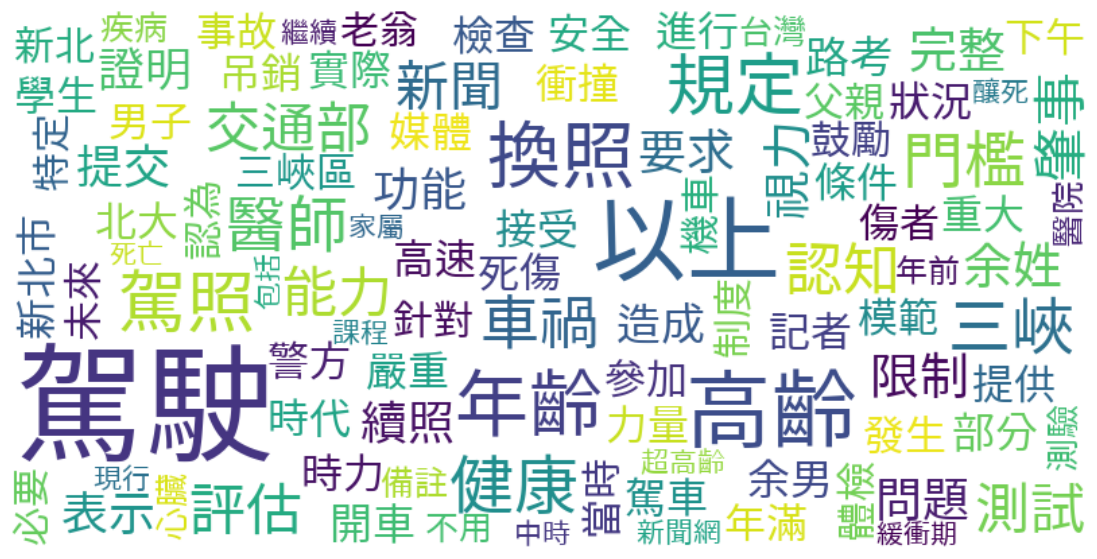

In [190]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
# stop_words_pos.extend((''))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

這張文字雲顯示在負面文章中出現頻率最高的詞彙

像是駕駛、駕照、高齡、門檻、能力、限制

出現大量關於駕駛資格、高齡駕駛安全性的討論

顯示輿論重點放在肇事原因（如駕駛資格、年齡規定）上

### 總結

針對 2025 年 5 月三峽地區發生的重大車禍事故，透過社群資料進行斷詞、命名實體辨識、情緒分類、主題建模，揭示出民眾對事件的關注焦點、情緒反應與話題走向。我們總結分析結果如下：

事件爆發時間（5/20）即為情緒與輿論最高峰，主軸為高齡駕駛與車禍責任。

輿論集中於：

1. 駕照制度與高齡者駕駛適格問題

2. 媒體報導與政界人物聲明

3. 家屬與民眾對後續醫療與處理效率的關心

隨時間推移，情緒逐步從強烈負向轉為平穩中性，社會討論逐漸冷靜。